In [1]:
import gym
import gvgai
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import torchvision.transforms as T
import torch.nn.functional as F


from tqdm import tqdm

from matplotlib import pyplot as plt

from agent.NNagent import NNagent
from torch.autograd import Variable

In [2]:
class Value(nn.Module):
    def __init__(self, depth):
        super(Value, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=depth, out_channels=8, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=3)
        self.fc = nn.Linear((32 * 3) + 4, 1)

    def forward(self, x, compass):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = x.view(len(x), 32 * 3)
        x = torch.cat([x, compass], dim=1)
        x = F.relu(self.fc(x))
        return x

In [3]:
from generator.env_gen_wrapper import GridGame

env = GridGame(game='dzelda', 
                      play_length=1000, 
                      path='./levels',
                      lvl_name='1.txt',
                      mechanics=['+', 'g'], # monsters, key, door, wall
                      images=False,
                  )

In [5]:
GAMMA = 0.99

total_rewards = []
total_estimate_rewards = []

for baseline in ['none', 'estimate']:
    policy = NNagent(GG=None, actions=6, depth=13)
    optimizer = optim.Adam(policy.nn.parameters(), lr=.002)
    eps = np.finfo(np.float32).eps.item()
    
    V = Value(13)
    V.double()

    v_loss = nn.MSELoss()
    v_optimizer = optim.SGD(V.parameters(), lr=0.01)
    for i in tqdm(range(10000)):
        state = env.reset()

        rewards = []
        states = [state]
        compass_info = []
        log_probs = []

        terminal = False

        while not terminal:
            # Action selection
            probs = policy.rl_get_action(state)
            compass_info.append(policy.compass_info)
            c = Categorical(probs)
            action = c.sample()
            log_probs.append(c.log_prob(action))

            # Carry out the action
            state, reward, terminal, _ = env.step(action.item())

            if not terminal:
                states.append(state)

            rewards.append(reward)

        if baseline == 'estimate':
            total_estimate_rewards.append(sum(rewards))
        else:
            total_rewards.append(sum(rewards))

        # Calculate the returns
        R = 0
        returns = []
        for r in reversed(rewards):
            R = r + GAMMA * R
            returns.insert(0, R)
        returns = torch.tensor(returns)

        values = V(torch.DoubleTensor(states), 
                   torch.DoubleTensor(np.vstack(compass_info)))

        if baseline == 'estimate':
            returns = returns - values.data.squeeze()

        # Calculate the loss
        policy_loss = [-log_prob * R for log_prob, R in zip(log_probs, returns)]

        # Backprop for the NN
        optimizer.zero_grad()
        policy_loss = torch.stack(policy_loss, dim=0).sum()
        policy_loss.backward()
        optimizer.step()

        # Backprop for the value estimator
        v_optimizer.zero_grad()
        estimate_loss = v_loss(values.squeeze(), returns.double())
        estimate_loss.backward()
        v_optimizer.step()
        
        # put check here to break if complete?
    
    name = 'baseline' if baseline == 'estimate' else 'simple'
    
    torch.save(V, f'./results/RL/{name}_model_value.pt')
    torch.save(policy.nn, f'./results/RL/{name}_model_policy.pt')

100%|██████████| 10000/10000 [7:50:54<00:00,  2.83s/it]  
/home/aadharna/miniconda3/envs/thesis/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Value. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/aadharna/miniconda3/envs/thesis/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/aadharna/miniconda3/envs/thesis/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MaxPool2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/aadharna/miniconda3/envs/thesis/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source c

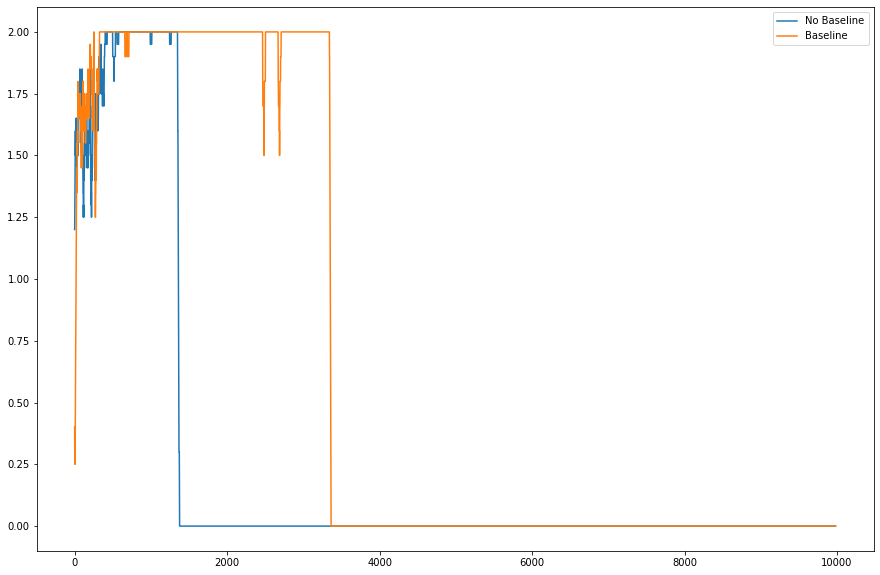

In [13]:
N=20
plt.figure(figsize=(15,10))
plt.plot(np.convolve(total_rewards, np.ones((N,))/N, mode='valid'), label='No Baseline')
plt.plot(np.convolve(total_estimate_rewards, np.ones((N,))/N, mode='valid'), label='Baseline')
plt.legend()
plt.show()

In [7]:
plt.savefig('./results/RL/reward_plot.jpg')

<Figure size 432x288 with 0 Axes>